In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [3]:
labeled = pd.read_csv("./data/labeled_data.csv")
unlabeled = pd.read_csv("./data/unlabeled_data.csv")

In [4]:
labeled_cn7 = labeled[(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") |(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]
unlabeled_cn7 = unlabeled[(unlabeled["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") |(unlabeled["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]

In [5]:
labeled_cn7 = labeled_cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "Reason", "PART_FACT_SERIAL", "PART_NAME",
               "EQUIP_NAME", "EQUIP_CD", "Switch_Over_Position", "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5",
                "Mold_Temperature_6", "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
               "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7"])

In [6]:
labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',0).replace('N',1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4868\1196971330.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',0).replace('N',1)


In [7]:
### Clamp_Open_Position에서 눈에띄게 낮은 값들 제거
cn7 = labeled_cn7[labeled_cn7["Clamp_Open_Position"]>=200]

In [8]:
cn7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6700 entries, 0 to 7995
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6700 non-null   int64  
 1   Injection_Time            6700 non-null   float64
 2   Filling_Time              6700 non-null   float64
 3   Plasticizing_Time         6700 non-null   float64
 4   Cycle_Time                6700 non-null   float64
 5   Clamp_Close_Time          6700 non-null   float64
 6   Cushion_Position          6700 non-null   float64
 7   Plasticizing_Position     6700 non-null   float64
 8   Clamp_Open_Position       6700 non-null   float64
 9   Max_Injection_Speed       6700 non-null   float64
 10  Max_Screw_RPM             6700 non-null   float64
 11  Average_Screw_RPM         6700 non-null   float64
 12  Max_Injection_Pressure    6700 non-null   float64
 13  Max_Switch_Over_Pressure  6700 non-null   float64
 14  Max_Back_Pres

In [9]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df


col_list = [ 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
           'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
           'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
           'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
           'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
           'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
           'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
           'Barrel_Temperature_6', 'Hopper_Temperature']

tmp = cn7.copy()

for col in col_list:
    tmp = remove_outliers(tmp, col)

In [10]:
tmp = cn7.copy()

In [11]:
tmp = remove_outliers(tmp, "Injection_Time")

In [12]:
tmp[tmp["PassOrFail"]==0]

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,0,9.59,4.47,16.920000,59.520000,7.13,653.409973,68.849998,647.98999,55.400002,...,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.500000
1,0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
2,0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
3,0,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
4,0,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,0,9.60,4.48,16.620001,59.560001,7.11,653.429993,68.330002,647.98999,54.900002,...,59.900002,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,66.099998,21.000000,22.400000
7992,0,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,...,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7993,0,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,...,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7994,0,9.60,4.48,16.629999,59.580002,7.11,653.429993,68.330002,647.98999,54.900002,...,59.900002,276.100006,275.799988,275.000000,271.299988,255.100006,230.199997,65.199997,21.000000,22.299999


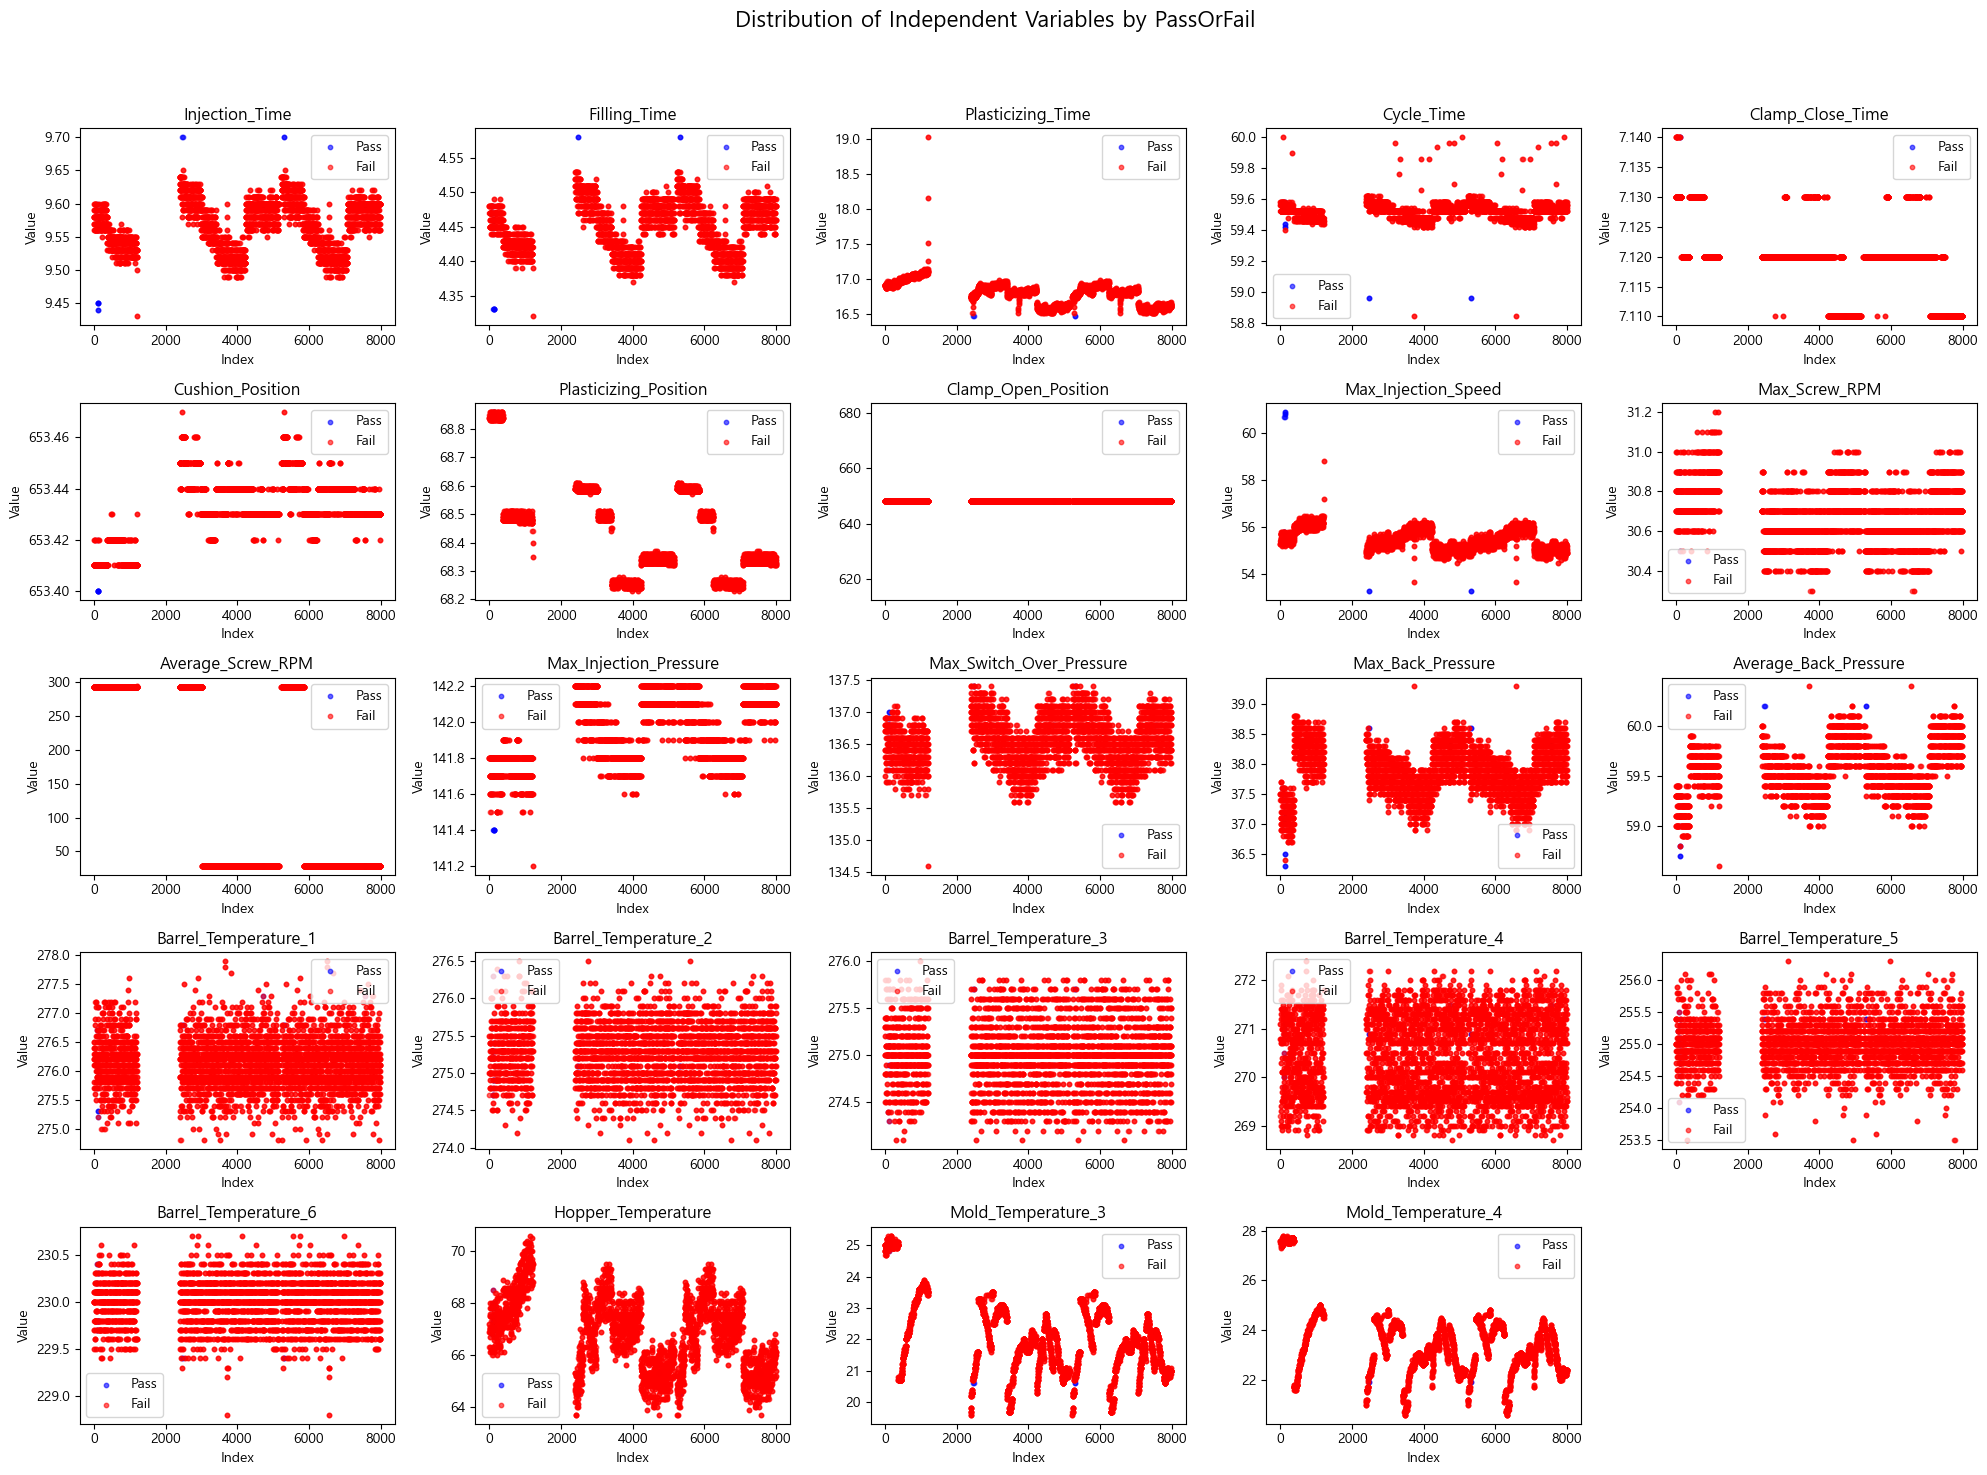

In [13]:
# 독립 변수와 종속 변수 분리
X = tmp.drop(columns=["PassOrFail"])
y = tmp["PassOrFail"]

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
tmp = remove_outliers(tmp, "Plasticizing_Time")

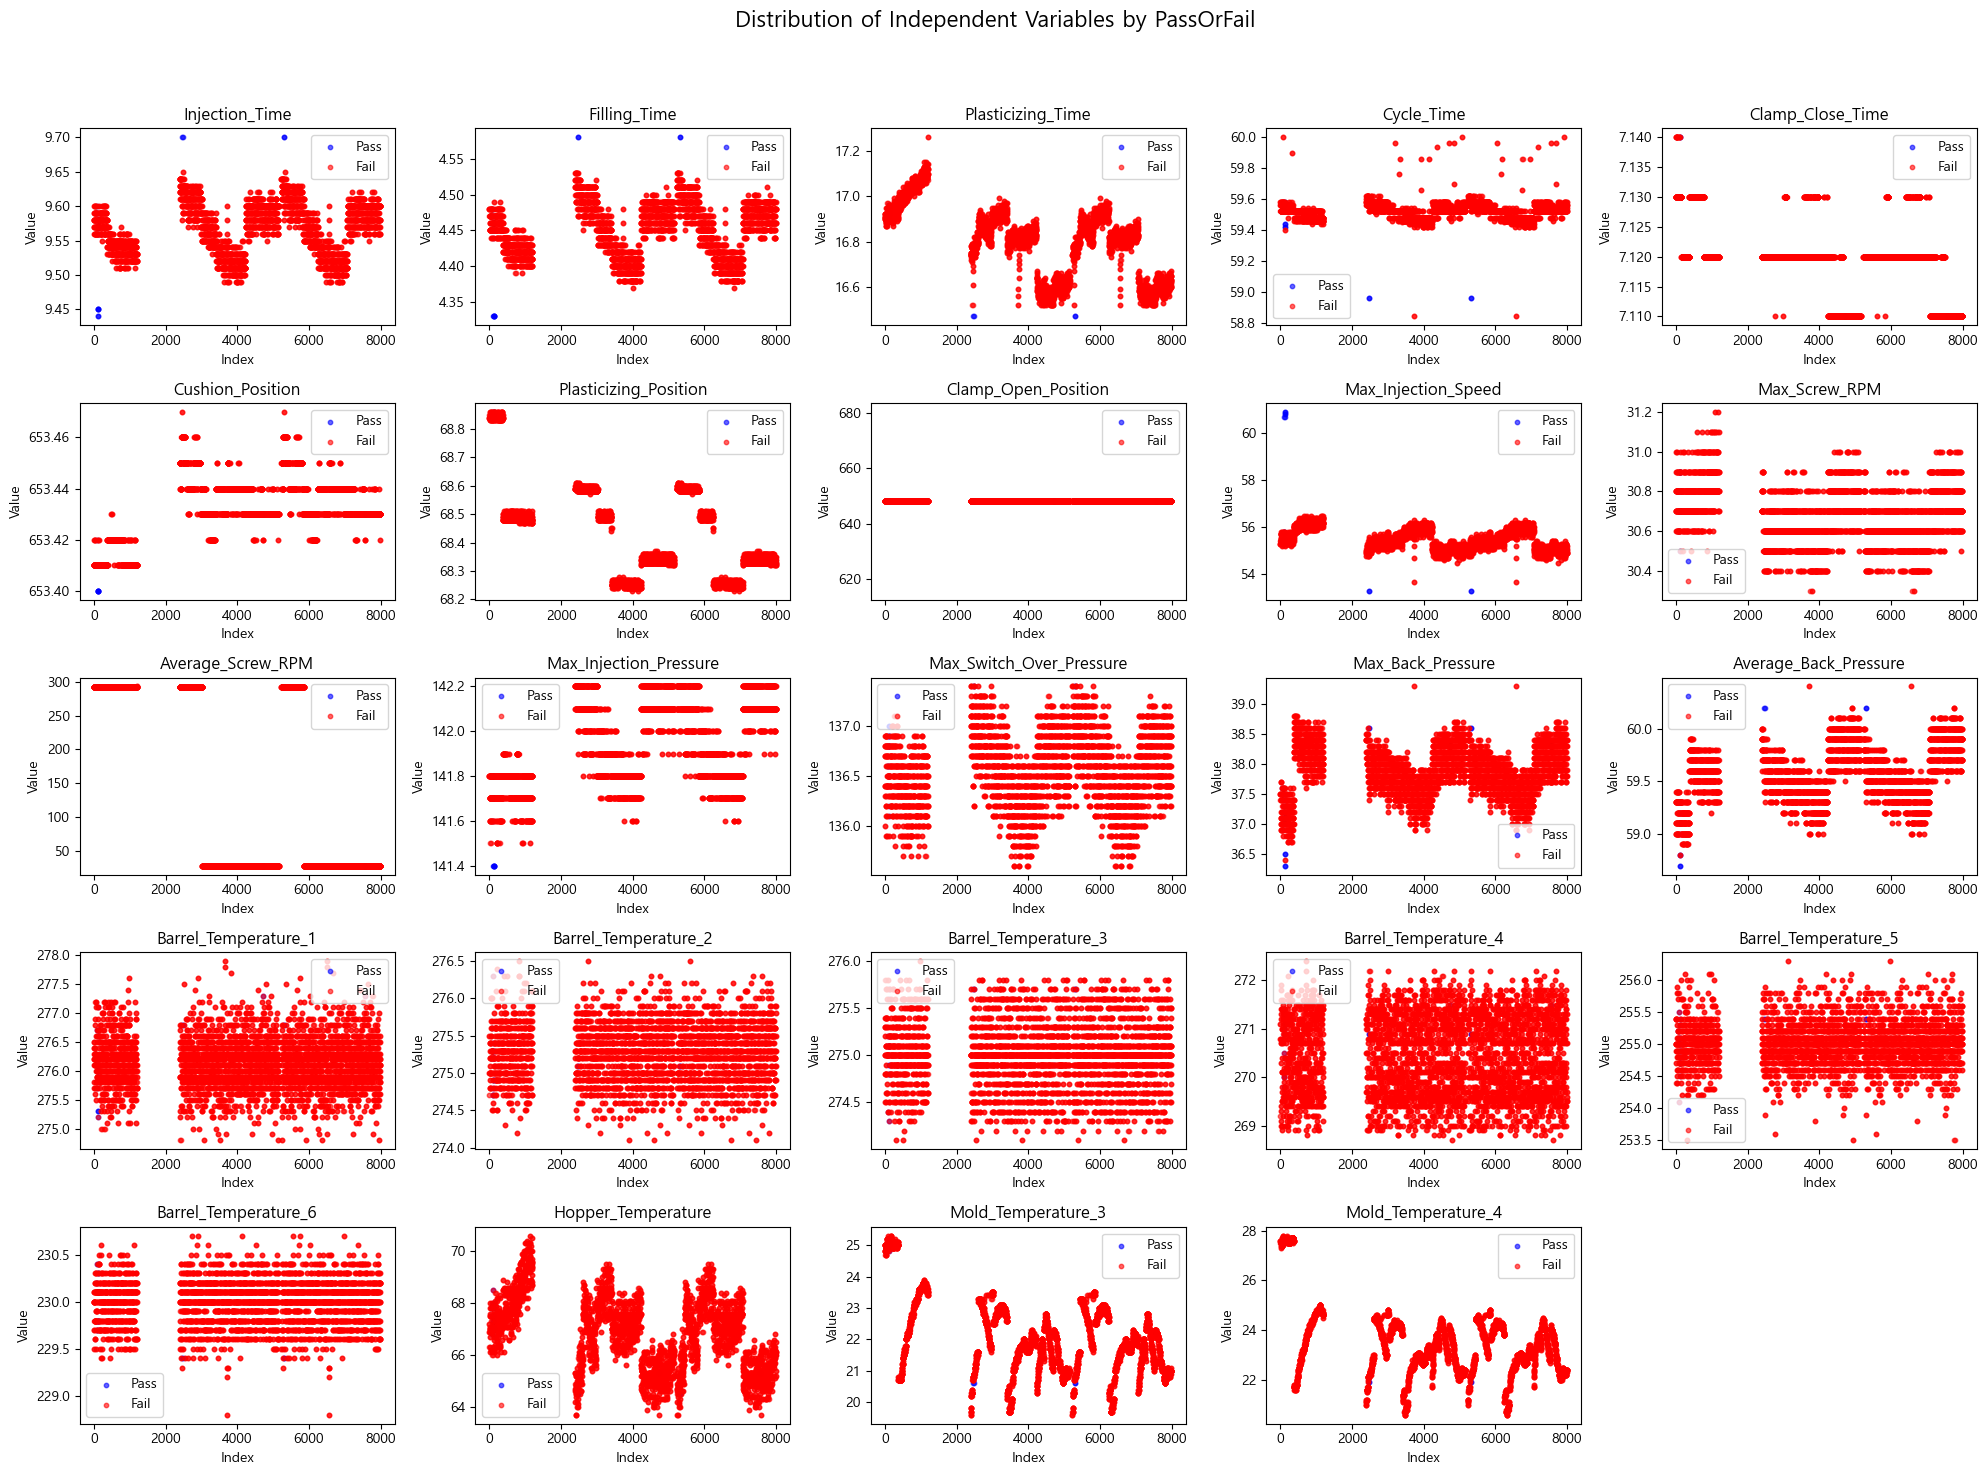

In [15]:
# 독립 변수와 종속 변수 분리
X = tmp.drop(columns=["PassOrFail"])
y = tmp["PassOrFail"]

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
tmp.columns

Index(['PassOrFail', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed',
       'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

In [17]:
tmp = remove_outliers(tmp, "Cycle_Time") #4개 탈락
cn7_removed_1 = tmp.copy()
cn7_removed_1["PassOrFail"].value_counts()

PassOrFail
0    6597
1      19
Name: count, dtype: int64

In [18]:
tmp[tmp["PassOrFail"]==0]

,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,0,9.59,4.47,16.920000,59.520000,7.13,653.409973,68.849998,647.98999,55.400002,...,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,66.300003,24.799999,27.500000
1,0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
2,0,9.60,4.48,16.910000,59.580002,7.13,653.409973,68.839996,647.98999,55.299999,...,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,67.199997,24.799999,27.600000
3,0,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
4,0,9.59,4.48,16.910000,59.560001,7.13,653.419983,68.839996,647.98999,55.299999,...,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,66.900002,25.000000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,0,9.60,4.48,16.620001,59.560001,7.11,653.429993,68.330002,647.98999,54.900002,...,59.900002,276.500000,274.899994,275.100006,269.500000,255.600006,229.600006,66.099998,21.000000,22.400000
7992,0,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,...,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7993,0,9.60,4.48,16.650000,59.560001,7.11,653.429993,68.349998,647.98999,55.000000,...,59.900002,275.799988,275.299988,275.500000,270.700012,254.899994,230.000000,66.099998,21.000000,22.400000
7994,0,9.60,4.48,16.629999,59.580002,7.11,653.429993,68.330002,647.98999,54.900002,...,59.900002,276.100006,275.799988,275.000000,271.299988,255.100006,230.199997,65.199997,21.000000,22.299999


In [19]:
tmp = remove_outliers(tmp, "Max_Injection_Speed") #6개 탈락

In [20]:
tmp = remove_outliers(tmp, "Mold_Temperature_3") #3개 탈락
cn7_removed_2 = tmp.copy()
cn7_removed_2["PassOrFail"].value_counts()

PassOrFail
0    6534
1      10
Name: count, dtype: int64

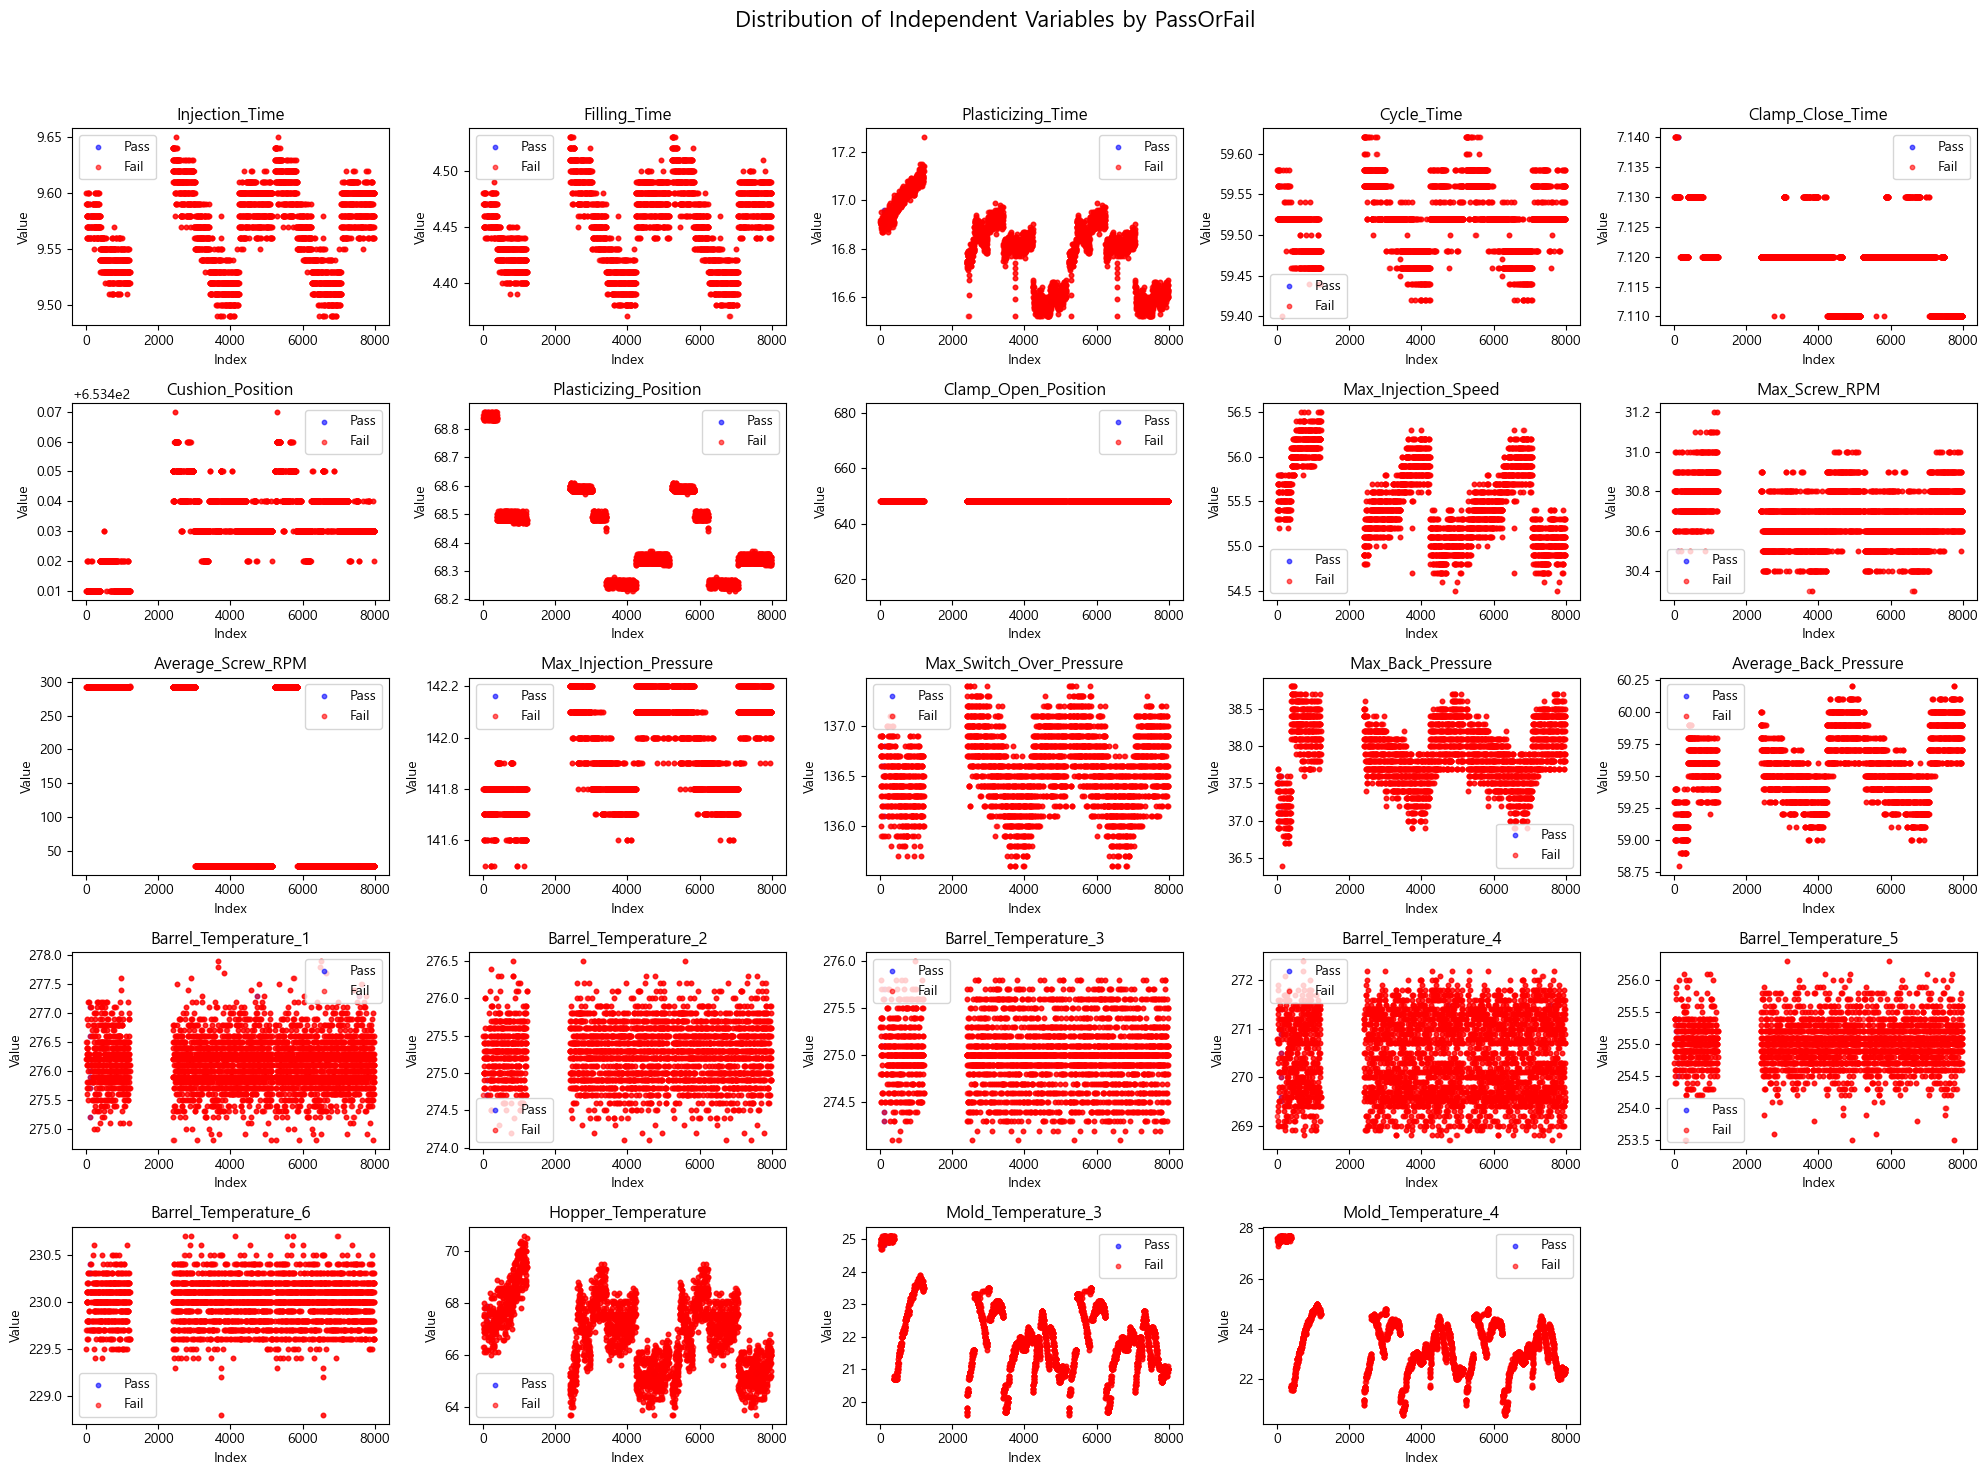

In [21]:
# 독립 변수와 종속 변수 분리
X = tmp.drop(columns=["PassOrFail"])
y = tmp["PassOrFail"]

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [22]:
cn7_Y = cn7[cn7["PassOrFail"]==1].copy()
print("CN7의 양품 개수:", len(cn7_Y))
cn7_N = cn7[cn7["PassOrFail"]==0].copy()
print("CN7의 불량 개수:", len(cn7_N))

CN7의 양품 개수: 39
CN7의 불량 개수: 6661


In [23]:
tmp1 = cn7_Y.copy()

In [24]:
tmp1 = remove_outliers(tmp1, "Injection_Time")
tmp1 = remove_outliers(tmp1, "Plasticizing_Time")
tmp1 = remove_outliers(tmp1, "Cycle_Time")
tmp1 = remove_outliers(tmp1, "Max_Injection_Speed")
tmp1 = remove_outliers(tmp1, "Mold_Temperature_3")

In [25]:
cn7_pass_removed = tmp1.copy()

In [26]:
cn7_pass_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 47 to 7564
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                17 non-null     int64  
 1   Injection_Time            17 non-null     float64
 2   Filling_Time              17 non-null     float64
 3   Plasticizing_Time         17 non-null     float64
 4   Cycle_Time                17 non-null     float64
 5   Clamp_Close_Time          17 non-null     float64
 6   Cushion_Position          17 non-null     float64
 7   Plasticizing_Position     17 non-null     float64
 8   Clamp_Open_Position       17 non-null     float64
 9   Max_Injection_Speed       17 non-null     float64
 10  Max_Screw_RPM             17 non-null     float64
 11  Average_Screw_RPM         17 non-null     float64
 12  Max_Injection_Pressure    17 non-null     float64
 13  Max_Switch_Over_Pressure  17 non-null     float64
 14  Max_Back_Press

In [27]:
cn7_removed_3 = pd.concat([cn7_pass_removed, cn7_N], ignore_index=True)

In [28]:
cn7_removed_3["PassOrFail"].value_counts()

PassOrFail
0    6661
1      17
Name: count, dtype: int64

### 데이터 증강

In [29]:
X = cn7.drop(columns=["PassOrFail"])
y = cn7["PassOrFail"]

In [30]:

from sklearn.model_selection import train_test_split
X = cn7.drop(columns=["PassOrFail"])
y = cn7["PassOrFail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4690, 24), (2010, 24), (4690,), (2010,))

In [31]:
from imblearn.over_sampling import SMOTE
# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled, test_size=0.3, random_state=42)
# 결과 확인
print("원본 데이터 분포:\n", y_train.value_counts())
print("SMOTE 적용 후 데이터 분포:\n", pd.Series(y_resampled).value_counts())

원본 데이터 분포:
 PassOrFail
1    3282
0    3244
Name: count, dtype: int64
SMOTE 적용 후 데이터 분포:
 PassOrFail
0    4662
1    4662
Name: count, dtype: int64


In [32]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_resampled)
X_train_scaled = ss.transform(X_resampled)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

model_list = [rf, et, gb, hgb, xgb]

grid_df = pd.DataFrame()
# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_resampled)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    train_acc = accuracy_score(y_resampled, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    df_temp = pd.DataFrame([[model_name, train_acc, val_acc, pre, rec, f1, train_acc-val_acc, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련정확도", "검증정확도", 
                                      "정밀도", "재현율", "f1-score", "훈련-검증",  "파라미터"])
    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련정확도,검증정확도,정밀도,재현율,f1-score,훈련-검증,파라미터
0,RandomForestClassifier,0.999249,0.999285,0.998553,1.0,0.999276,-0.000036,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.999571,0.999285,0.998553,1.0,0.999276,0.000286,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999571,0.999285,0.998553,1.0,0.999276,0.000286,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999571,0.999285,0.998553,1.0,0.999276,0.000286,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999571,0.999285,0.998553,1.0,0.999276,0.000286,"{'max_depth': 10, 'min_child_weight': 4, 'n_es..."


In [34]:
#RandomForest
grid_df["파라미터"][0]

"{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}"

In [35]:
model = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50)

In [36]:
from sklearn.metrics import confusion_matrix
model.fit(X_train_scaled, y_resampled)
val_pred = model.predict(X_test_scaled)
confusion_matrix(val_pred, y_test)

array([[1997,    7],
       [   2,    4]], dtype=int64)

In [37]:
from sklearn.metrics import confusion_matrix
X_test_scaled = ss.transform(X_test)

model.fit(X_train_scaled, y_resampled)
val_pred = model.predict(X_test_scaled)
confusion_matrix(val_pred, y_test)

array([[1997,    7],
       [   2,    4]], dtype=int64)

In [38]:
X = cn7_removed_1.drop(columns=["PassOrFail"])
y = cn7_removed_1["PassOrFail"]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape


from imblearn.over_sampling import SMOTE
# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_resampled)
X_train_scaled = ss.transform(X_resampled)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)


rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

model_list = [rf, et, gb, hgb, xgb]

grid_df = pd.DataFrame()
# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_resampled)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    train_acc = accuracy_score(y_resampled, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    df_temp = pd.DataFrame([[model_name, train_acc, val_acc, pre, rec, f1, train_acc-val_acc, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련정확도", "검증정확도", 
                                      "정밀도", "재현율", "f1-score", "훈련-검증",  "파라미터"])
    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련정확도,검증정확도,정밀도,재현율,f1-score,훈련-검증,파라미터
0,RandomForestClassifier,0.999459,0.999278,1.000000,0.998538,0.999268,0.000180,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999350,0.999278,0.998540,1.000000,0.999270,0.000072,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
2,GradientBoostingClassifier,0.999459,0.998917,0.999268,0.998538,0.998903,0.000541,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
3,HistGradientBoostingClassifier,0.999459,0.999639,1.000000,0.999269,0.999634,-0.000180,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999459,0.999639,0.999270,1.000000,0.999635,-0.000180,"{'max_depth': 10, 'min_child_weight': 4, 'n_es..."


In [39]:
#RandomForest
grid_df["파라미터"][0]

"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}"

In [40]:
model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50)

In [41]:
model.fit(X_train_scaled, y_resampled)
val_pred = model.predict(X_test_scaled)
confusion_matrix(val_pred, y_test)

array([[1977,    6],
       [   2,    0]], dtype=int64)

In [42]:
X = cn7_removed_3.drop(columns=["PassOrFail"])
y = cn7_removed_3["PassOrFail"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

from imblearn.over_sampling import SMOTE
# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_resampled)
X_train_scaled = ss.transform(X_resampled)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)


rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

model_list = [rf, et, gb, hgb, xgb]

grid_df = pd.DataFrame()
# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_resampled)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    train_acc = accuracy_score(y_resampled, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    df_temp = pd.DataFrame([[model_name, train_acc, val_acc, pre, rec, f1, train_acc-val_acc, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련정확도", "검증정확도", 
                                      "정밀도", "재현율", "f1-score", "훈련-검증",  "파라미터"])
    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련정확도,검증정확도,정밀도,재현율,f1-score,훈련-검증,파라미터
0,RandomForestClassifier,0.998820,0.998212,0.997108,0.999275,0.998190,0.000608,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.998927,0.998212,0.996390,1.000000,0.998192,0.000715,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.998927,0.998570,0.997110,1.000000,0.998553,0.000357,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
3,HistGradientBoostingClassifier,0.998927,0.998212,0.996390,1.000000,0.998192,0.000715,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.998820,0.998212,0.996390,1.000000,0.998192,0.000608,"{'max_depth': 10, 'min_child_weight': 4, 'n_es..."


In [43]:
#RandomForest
grid_df["파라미터"][4]

"{'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 50}"

In [44]:
model = XGBClassifier(max_depth=10, min_child_weight=2, n_estimators=50)

In [45]:
from sklearn.metrics import confusion_matrix
model.fit(X_train_scaled, y_resampled)
val_pred = model.predict(X_val_scaled)
confusion_matrix(val_pred, y_val)

array([[1412,    0],
       [   5, 1380]], dtype=int64)

### cn7

In [46]:
grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7["PassOrFail"]
X = cn7.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [47]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999387,0.998570,0.997110,1.000000,0.998553,0.000817,1995,4,5,6,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999694,0.999285,0.998553,1.000000,0.999276,0.000408,1997,2,7,4,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999694,0.998213,0.998550,0.997826,0.998188,0.001481,1991,8,6,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999540,0.997856,0.998549,0.997101,0.997825,0.001685,1991,8,5,6,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999694,0.997141,0.994949,0.999275,0.997108,0.002553,1991,8,6,5,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


In [48]:
# 독립변수 종속변수 분리 
y = cn7_removed_1["PassOrFail"]
X = cn7_removed_1.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [49]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999387,0.998570,0.997110,1.000000,0.998553,0.000817,1995,4,5,6,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999694,0.999285,0.998553,1.000000,0.999276,0.000408,1997,2,7,4,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999694,0.998213,0.998550,0.997826,0.998188,0.001481,1991,8,6,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999540,0.997856,0.998549,0.997101,0.997825,0.001685,1991,8,5,6,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999694,0.997141,0.994949,0.999275,0.997108,0.002553,1991,8,6,5,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."
5,RandomForestClassifier,0.999536,0.998556,1.000000,0.997076,0.998536,0.000979,1975,4,6,0,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
6,ExtraTreesClassifier,0.999536,0.998917,0.997812,1.000000,0.998905,0.000619,1973,6,5,1,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
7,GradientBoostingClassifier,0.999691,0.997474,0.999266,0.995614,0.997437,0.002217,1974,5,5,1,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
8,HistGradientBoostingClassifier,0.999691,0.998196,0.998537,0.997807,0.998172,0.001495,1973,6,5,1,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
9,XGBClassifier,0.999536,0.997113,0.996350,0.997807,0.997078,0.002423,1972,7,4,2,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


### cn7_removed_3

In [50]:
# 독립변수 종속변수 분리 
y = cn7_removed_3["PassOrFail"]
X = cn7_removed_3.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [51]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999387,0.998570,0.997110,1.000000,0.998553,0.000817,1995,4,5,6,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999694,0.999285,0.998553,1.000000,0.999276,0.000408,1997,2,7,4,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999694,0.998213,0.998550,0.997826,0.998188,0.001481,1991,8,6,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999540,0.997856,0.998549,0.997101,0.997825,0.001685,1991,8,5,6,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999694,0.997141,0.994949,0.999275,0.997108,0.002553,1991,8,6,5,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."
5,RandomForestClassifier,0.999536,0.998556,1.000000,0.997076,0.998536,0.000979,1975,4,6,0,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
6,ExtraTreesClassifier,0.999536,0.998917,0.997812,1.000000,0.998905,0.000619,1973,6,5,1,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
7,GradientBoostingClassifier,0.999691,0.997474,0.999266,0.995614,0.997437,0.002217,1974,5,5,1,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
8,HistGradientBoostingClassifier,0.999691,0.998196,0.998537,0.997807,0.998172,0.001495,1973,6,5,1,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
9,XGBClassifier,0.999536,0.997113,0.996350,0.997807,0.997078,0.002423,1972,7,4,2,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


### Average_Screw_RPM 에서 up만 사용

### cn7

In [52]:
# 독립변수 종속변수 분리 
y = cn7["PassOrFail"]
X = cn7.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [53]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999387,0.998570,0.997110,1.000000,0.998553,0.000817,1995,4,5,6,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999694,0.999285,0.998553,1.000000,0.999276,0.000408,1997,2,7,4,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999694,0.998213,0.998550,0.997826,0.998188,0.001481,1991,8,6,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999540,0.997856,0.998549,0.997101,0.997825,0.001685,1991,8,5,6,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999694,0.997141,0.994949,0.999275,0.997108,0.002553,1991,8,6,5,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."
5,RandomForestClassifier,0.999536,0.998556,1.000000,0.997076,0.998536,0.000979,1975,4,6,0,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
6,ExtraTreesClassifier,0.999536,0.998917,0.997812,1.000000,0.998905,0.000619,1973,6,5,1,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
7,GradientBoostingClassifier,0.999691,0.997474,0.999266,0.995614,0.997437,0.002217,1974,5,5,1,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
8,HistGradientBoostingClassifier,0.999691,0.998196,0.998537,0.997807,0.998172,0.001495,1973,6,5,1,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
9,XGBClassifier,0.999536,0.997113,0.996350,0.997807,0.997078,0.002423,1972,7,4,2,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


### cn7_removed_1

In [54]:
# 독립변수 종속변수 분리 
y = cn7_removed_1["PassOrFail"]
X = cn7_removed_1.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [55]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999387,0.998570,0.997110,1.000000,0.998553,0.000817,1995,4,5,6,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999694,0.999285,0.998553,1.000000,0.999276,0.000408,1997,2,7,4,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999694,0.998213,0.998550,0.997826,0.998188,0.001481,1991,8,6,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999540,0.997856,0.998549,0.997101,0.997825,0.001685,1991,8,5,6,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999694,0.997141,0.994949,0.999275,0.997108,0.002553,1991,8,6,5,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."
5,RandomForestClassifier,0.999536,0.998556,1.000000,0.997076,0.998536,0.000979,1975,4,6,0,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
6,ExtraTreesClassifier,0.999536,0.998917,0.997812,1.000000,0.998905,0.000619,1973,6,5,1,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
7,GradientBoostingClassifier,0.999691,0.997474,0.999266,0.995614,0.997437,0.002217,1974,5,5,1,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
8,HistGradientBoostingClassifier,0.999691,0.998196,0.998537,0.997807,0.998172,0.001495,1973,6,5,1,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
9,XGBClassifier,0.999536,0.997113,0.996350,0.997807,0.997078,0.002423,1972,7,4,2,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


### cn7_removed_3

In [56]:
# 독립변수 종속변수 분리 
y = cn7_removed_3["PassOrFail"]
X = cn7_removed_3.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [57]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999387,0.998570,0.997110,1.000000,0.998553,0.000817,1995,4,5,6,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999694,0.999285,0.998553,1.000000,0.999276,0.000408,1997,2,7,4,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999694,0.998213,0.998550,0.997826,0.998188,0.001481,1991,8,6,5,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999540,0.997856,0.998549,0.997101,0.997825,0.001685,1991,8,5,6,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999694,0.997141,0.994949,0.999275,0.997108,0.002553,1991,8,6,5,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."
5,RandomForestClassifier,0.999536,0.998556,1.000000,0.997076,0.998536,0.000979,1975,4,6,0,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
6,ExtraTreesClassifier,0.999536,0.998917,0.997812,1.000000,0.998905,0.000619,1973,6,5,1,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
7,GradientBoostingClassifier,0.999691,0.997474,0.999266,0.995614,0.997437,0.002217,1974,5,5,1,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
8,HistGradientBoostingClassifier,0.999691,0.998196,0.998537,0.997807,0.998172,0.001495,1973,6,5,1,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
9,XGBClassifier,0.999536,0.997113,0.996350,0.997807,0.997078,0.002423,1972,7,4,2,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


In [58]:
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from collections import Counter

# 독립변수 종속변수 분리 
y = cn7_removed_2["PassOrFail"]
X = cn7_removed_2.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# 데이터 증강
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화

ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

df_temp

KeyboardInterrupt: 

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from collections import Counter

# 독립변수 종속변수 분리 
y = cn7["PassOrFail"]
X = cn7.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

df_temp

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from collections import Counter

# 독립변수 종속변수 분리 
y = cn7["PassOrFail"]
X = cn7.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# 데이터 증강
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

df_temp

In [ ]:
# 독립 변수와 종속 변수 분리

tmp_re = X_resampled.copy()
tmp_re["PassOrFail"] = y_resampled

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(tmp_re.index[y_resampled == 1], tmp_re[column][y_resampled == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(tmp_re.index[y_resampled == 0], tmp_re[column][y_resampled == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# 독립변수 종속변수 분리 
y = cn7["PassOrFail"]
X = cn7.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
X_resampled.shape, y_resampled.shape

In [ ]:
# 독립 변수와 종속 변수 분리

tmp_re = X_resampled.copy()
tmp_re["PassOrFail"] = y_resampled

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(tmp_re.index[y_resampled == 1], tmp_re[column][y_resampled == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(tmp_re.index[y_resampled == 0], tmp_re[column][y_resampled == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 